### Imports

In [56]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_distribution
from qiskit import Aer, transpile

import matplotlib.pyplot as plt
import numpy as np

In [57]:
np.random.seed(35)

### Ideal calculations:

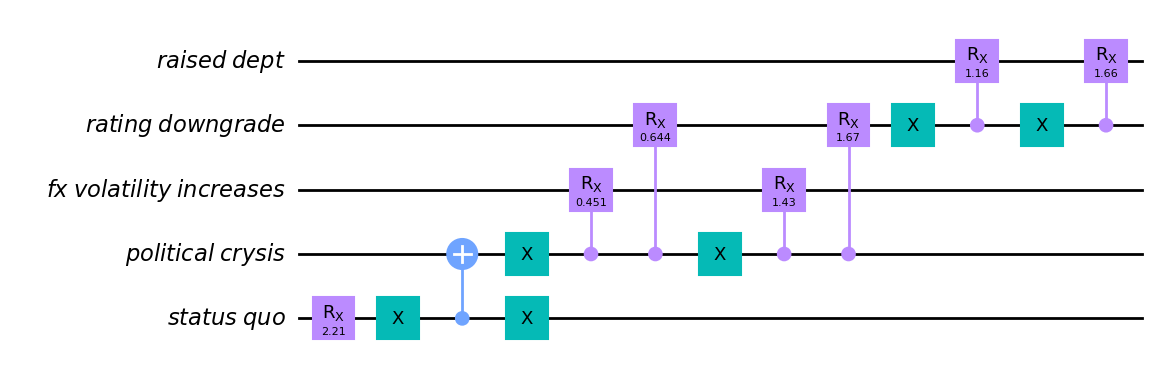

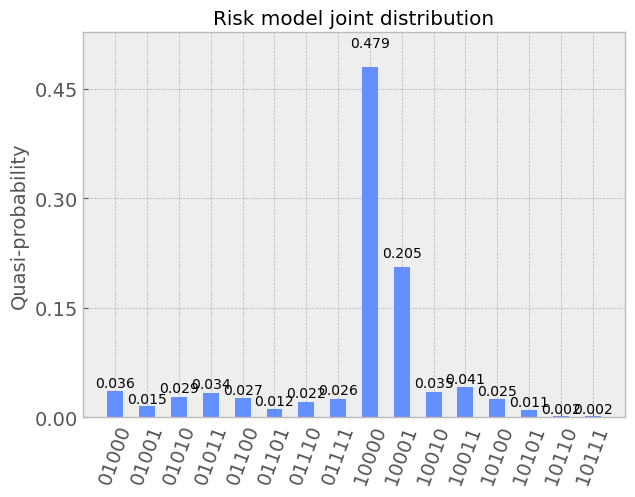

{'01000': 0.03591, '01001': 0.01539, '01010': 0.0285285, '01011': 0.0341715, '01100': 0.02709, '01101': 0.01161, '01110': 0.0215215, '01111': 0.0257785, '10000': 0.4788, '10001': 0.2052, '10010': 0.03458, '10011': 0.04142, '10100': 0.0252, '10101': 0.0108, '10110': 0.00182, '10111': 0.00218}


In [58]:
import qiskit as q


plt.style.use('ggplot')

status_quo = q.QuantumRegister(1, name='status quo')
political_crysis = q.QuantumRegister(1, name='political crysis')
fx_volatility_increases = q.QuantumRegister(1, name='fx volatility increases')
rating_downgrade = q.QuantumRegister(1, name='rating downgrade')
raised_dept = q.QuantumRegister(1, name='raised dept')


# Helper converter function
p_to_theta = lambda x: 2*np.arcsin(np.sqrt(x))

# Create the circuit
risk_model = q.QuantumCircuit(raised_dept, rating_downgrade, fx_volatility_increases, political_crysis, status_quo, name='Risk Model')

# Intrinsic status quo
risk_model.rx(p_to_theta(0.8), status_quo)

# Add the CNOT with the control state as '0'
risk_model.x(status_quo)
risk_model.cnot(status_quo, political_crysis)
risk_model.x(status_quo)


risk_model.x(political_crysis)
# The intrinsic probability for fx volatility increases occurs when there's no political crysis
risk_model.crx(p_to_theta(0.05), political_crysis, fx_volatility_increases)
# The intrinsic probability for rating downgrade occurs when there's no political crysis
risk_model.crx(p_to_theta(0.1), political_crysis, rating_downgrade)
risk_model.x(political_crysis)

# Calculate the P(fx volatility increases | political crysis)
p = 1 - (1 - 0.05) * (1 - 0.4)
risk_model.crx(p_to_theta(p), political_crysis, fx_volatility_increases, ctrl_state='1')

# Calculate the P(rating downgrade | political crysis)
p = 1 - (1 - 0.1) * (1 - 0.5)
risk_model.crx(p_to_theta(p), political_crysis, rating_downgrade, ctrl_state='1')


# The intrinsic probability for raised debt occurs when there's no rating downgrade
risk_model.x(rating_downgrade)
risk_model.crx(p_to_theta(0.3), rating_downgrade, raised_dept)
risk_model.x(rating_downgrade)


# Calculate the P(raised debt | rating downgrade)
p = 1 - (1 - 0.3) * (1 - 0.35)
risk_model.crx(p_to_theta(p), rating_downgrade, raised_dept, ctrl_state='1')


# Draw the circuit with matplotlib
display(risk_model.draw(output='mpl'))

risk_model.measure_all()

# simulator = Aer.get_backend('aer_simulator')
# job = simulator.run(risk_model, shots=None)

sampler = Sampler()
job = sampler.run(risk_model, shots=None)
qp = job.result().quasi_dists[0].binary_probabilities()
    

with plt.style.context('bmh'):
    display(plot_distribution(qp, title='Risk model joint distribution'))
print(qp)

### Noisy setup:

In [59]:
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


# QuantumError objects
error_gate1 = depolarizing_error(0.02,1)
error_gate2 = depolarizing_error(0.02,2)

# Add errors to noise model
noise_dep = NoiseModel()
noise_dep.add_all_qubit_quantum_error(error_gate1, ["rx","rz","ry","x"])
noise_dep.add_all_qubit_quantum_error(error_gate2, ["cx"])

# sim_noise = Aer.get_backend('aer_simulator', noise_model=noise_bit_flip)
sim_noise = AerSimulator(noise_model=noise_dep, seed_simulator=35)

### ZNE mitigation:

Transpilation for the noise model gates to applicable:

In [60]:
t_risk_model = transpile(risk_model, basis_gates=['rx','rz','ry','x','cx'], optimization_level=1)
display(t_risk_model.draw(fold=-1))

global phase: π
                           ┌─────────┐                                                                                                                                                                                                                                            ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───┐┌───────────────────────┐┌──────────┐ ░ ┌─┐            
            raised dept: ──┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.579639740363704) ├┤ X ├┤ Ry(0.57964) ├┤ X ├┤ Ry(-0.830459135904746) ├┤ X ├┤ Ry(0.830459135904746) ├┤ Rz(-π/2) ├─░─┤M├────────────
                           ├─────────┤                                                               ┌───┐┌────────────────────────┐┌───┐┌─────────────┐                                                           ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌──────────┐└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└─┬─┘└───────────────────────┘└──────────┘ ░ └╥┘┌─┐         
       rating downgrade: ──┤ Rz(π/2) ├───────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ Ry(0.32175) ├───────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(-2.3061) ├┤ Rz(-π/2) ├──■──────────────────────────────■───────┤ X ├───────■──────────────────────────────■────────────────────────────────────────░──╫─┤M├─────────
                           ├─────────┤            ┌───┐┌────────────────────────┐┌───┐┌─────────────┐└─┬─┘└────────────────────────┘└─┬─┘└─────────────┘┌───┐┌───────────────────────┐┌───┐┌──────────────────────┐└─┬─┘└──────┬──────────┬──────┘└─┬─┘└─────────────┘└──────────┘                                         └───┘                                                                               ░  ║ └╥┘┌─┐      
fx volatility increases: ──┤ Rz(π/2) ├────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ X ├┤ Ry(0.22551) ├──┼──────────────────────────────┼─────────────────┤ X ├┤ Ry(-0.71516745604252) ├┤ X ├┤ Ry(0.71516745604252) ├──┼─────────┤ Rz(-π/2) ├─────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├──────
                           └─────────┘  ┌───┐┌───┐└─┬─┘└────────────────────────┘└─┬─┘└─────────────┘  │                              │       ┌───┐     └─┬─┘└───────────────────────┘└─┬─┘└──────────────────────┘  │         └──────────┘         │                                                                                                                                                          ░  ║  ║ └╥┘┌─┐   
       political crysis: ───────────────┤ X ├┤ X ├──■──────────────────────────────■───────────────────■──────────────────────────────■───────┤ X ├───────■─────────────────────────────■────────────────────────────■──────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫──╫─┤M├───
                         ┌─────────────┐└─┬─┘├───┤                                                                                            └───┘                                                                                                                                                                                                                                                            ░  ║  ║  ║ └╥┘┌─┐
             status quo: ┤ Rx(-0.9273) ├──■──┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [61]:
from scipy.optimize import curve_fit


def get_locally_folded_circuit(circuit: QuantumCircuit, noise_factor:float):
    
    if noise_factor<1:
        raise ValueError("Noise factor descreasing noise. Only noise amplification is possible.")
    
    folded_circ = QuantumCircuit(*circuit.qregs)
    
    n_folds = int((noise_factor-1)//2)
    additional_fold_chance = ((noise_factor-1)/2)-n_folds
    
    
    for gate in circuit.data:
        folded_circ.append(*gate)
        for _ in range(n_folds):
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

        if additional_fold_chance>np.random.rand():
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

    return folded_circ
    
n_shots = 10000
noise_levels = [1, 2, 3]


qps_noisy = []
for noise_level in noise_levels:
    folded_circ = get_locally_folded_circuit(t_risk_model.remove_final_measurements(inplace=False),
                                              noise_factor=noise_level)
    
    folded_circ.measure_all()
    # print(f"Circuit for noise factor={noise_level}")
    # display(folded_circ.draw(fold=-1))
    
    job = sim_noise.run(folded_circ, shots=n_shots)
    qp_noisy = job.result().get_counts()
    qps_noisy.append(qp_noisy)


In [62]:

job = sim_noise.run(t_risk_model, shots=n_shots)
qp_noisy_new = job.result().get_counts()
states = list(qp.keys())


qp_noisy_probabilities = {state:qp_noisy_new[state]/n_shots for state in states}



C:\Users\adpach\AppData\Local\Temp\ipykernel_17040\2630064342.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))


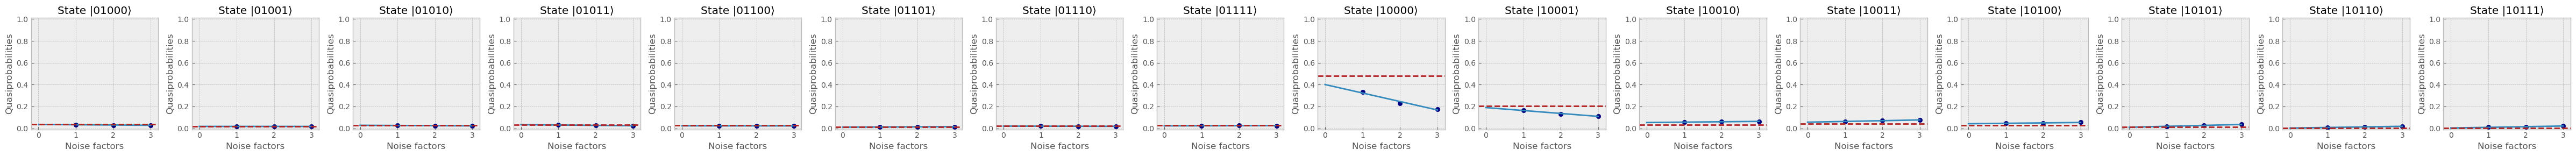

1.0000000000000002
1.137263220666503 0.9483666370074895


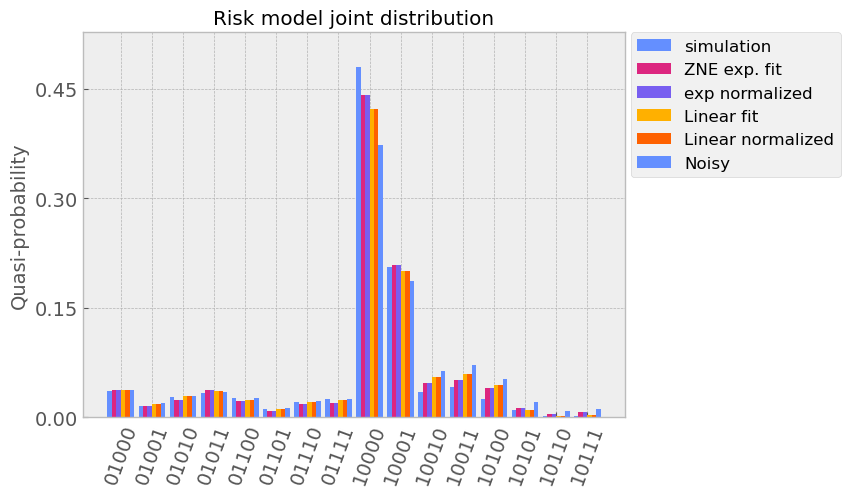

In [63]:
with plt.style.context('bmh'):
    states = list(qp.keys())
    
    fig, axs = plt.subplots(1,len(states),figsize=(3*len(states),3))
    
    mit_values_expfit = []
    linear_values = []
    for i, state in enumerate(states):
        state_probs = [qp_noisy[state]/n_shots for qp_noisy in qps_noisy]
        # Define the exponential function
        def exponential_function(x, a, b, c):
            return a * np.exp(b * x) + c
        
        def linear_function(x, m, c):
            return m * x + c

        # Fit the data using curve_fit
        popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))
        x_fit = np.linspace(0, max(noise_levels), 101)
        y_fit = exponential_function(x_fit, *popt)
        mit_values_expfit.append(y_fit[0])

        popt, pcov = curve_fit(linear_function, noise_levels, state_probs, bounds=(-1., 1.))
        x_fit = np.linspace(0, max(noise_levels), 101)
        y_fit = linear_function(x_fit, *popt)
        linear_values.append(y_fit[0])
        
        axs[i].scatter(noise_levels, state_probs, color='navy', label='raw probs')
        axs[i].plot(x_fit, y_fit, label='exp. func. fit')
        axs[i].axhline(qp[state], linestyle='--', color='firebrick', label=f'ideal prob={qp[state]:.2%}')
        
        axs[i].set_ylim(-0.01, 1.01)
        axs[i].set_xlim(-0.2, max(noise_levels)+0.2)
        axs[i].set_title(f'State |{state}⟩')
        axs[i].set_ylabel("Quasiprobabilities")
        axs[i].set_xlabel('Noise factors')
    # plt.legend()
    plt.tight_layout()
    plt.show()
    
exp_fit = {key:value for key, value in zip(states, mit_values_expfit)}
linear_fit = {key:value for key, value in zip(states, linear_values)}

print(sum([value for key,value in qp.items()]))
sum_of_probabilities_exp = sum([value for key,value in exp_fit.items()])
sum_of_probabilities_linear = sum([value for key,value in linear_fit.items()])
print(sum_of_probabilities_exp, sum_of_probabilities_linear)

exp_fit_normalized = {key:value/sum_of_probabilities_exp for key, value in exp_fit.items()}
linear_fit_normalized = {key:value/sum_of_probabilities_linear for key, value in linear_fit.items()}


with plt.style.context('bmh'):
    display(
        plot_distribution([qp,exp_fit, exp_fit_normalized, linear_fit, linear_fit_normalized, qp_noisy_probabilities], 
                          legend=['simulation','ZNE exp. fit', "exp normalized",'Linear fit', 'Linear normalized', 'Noisy'], 
                          title='Risk model joint distribution',
                          bar_labels=False))

### Objective function:

QPS NOISY {'11011': 121, '01100': 234, '11010': 113, '11100': 114, '10011': 633, '11000': 129, '10000': 3301, '01111': 225, '10010': 562, '01000': 333, '01010': 262, '01011': 309, '11110': 110, '10001': 1659, '11111': 112, '10100': 471, '01110': 203, '00000': 124, '00100': 32, '10101': 192, '10111': 104, '10110': 83, '11001': 62, '01001': 175, '01101': 119, '00001': 51, '00110': 6, '00011': 44, '00010': 29, '11101': 55, '00101': 24, '00111': 9}


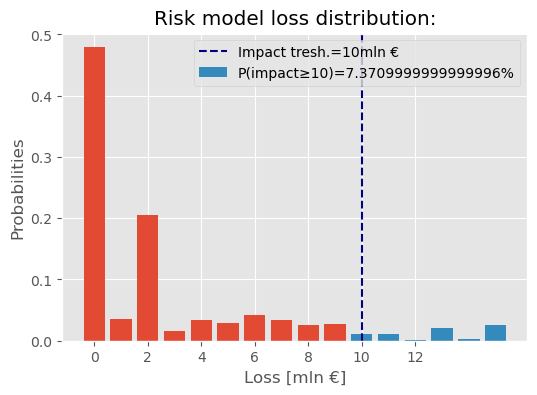

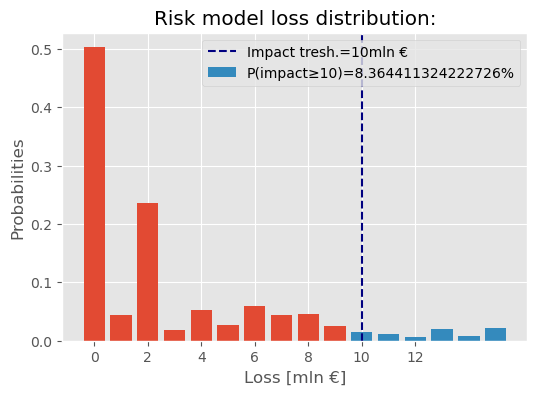

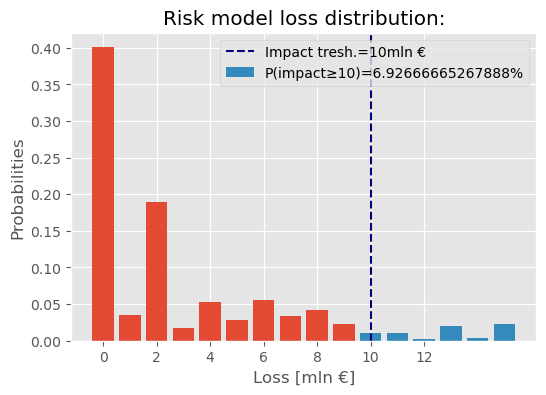

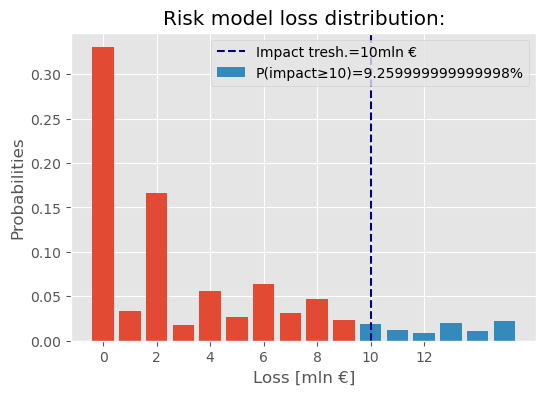

In [64]:
impacts = [2, 4, 8, 1, 0][::-1]
n_events = len(impacts)


# Calculated value
qps = np.zeros((2**n_events))

# Exponential
qps_exp = np.zeros((2**n_events))

# Exponential normalized
qps_exp_normalized = np.zeros((2**n_events))

# Linear
qps_linear = np.zeros((2**n_events))

# Linear normalized 
qps_linear_normalized = np.zeros((2**n_events))

# Without noise mitigation
qps_random = np.zeros((2**n_events))

print("QPS NOISY", qps_noisy[0])

# Calculated value
for key, value in qp.items():
    qps[int(key, base=2)] = value

# Exponential
for key, value in exp_fit.items():
    qps_exp[int(key, base=2)] = value

# Exponential normalized
for key, value in exp_fit_normalized.items():
    qps_exp_normalized[int(key, base=2)] = value

# Linear
for key, value in linear_fit.items():
    qps_linear[int(key, base=2)] = value

# Linear normalized
for key, value in linear_fit_normalized.items():
    qps_linear_normalized[int(key, base=2)] = value

# Without noise mitigation
for key, value in qp_noisy_probabilities.items():
    qps_random[int(key, base=2)] = value


occurencies = [format(i, f'0{n_events}b') for i in range(2**n_events)]
joint_impacts = [sum([impacts[impact_idx] if flag=='1' else 0 for impact_idx, flag in enumerate(occ)]) for occ in occurencies]
unique_joint_impacts = np.unique(joint_impacts)

# Calculated value
uji_qps = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps[imp_idx]+= qps[qps_idx]

# Exponential
uji_qps_exp = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps_exp[imp_idx]+= qps_exp[qps_idx]

# Exponential normalized
uji_qps_exp_normalized = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps_exp_normalized[imp_idx]+= qps_exp_normalized[qps_idx]

# Linear
uji_qps_linear = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps_linear[imp_idx]+= qps_linear[qps_idx]

# Linear normalized
uji_qps_linear_normalized = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps_linear_normalized[imp_idx]+= qps_linear_normalized[qps_idx]

# Without noise mitigation
uji_qps_random = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps_random[imp_idx]+= qps_random[qps_idx]


threshold = 10

plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps)
plt.bar(unique_joint_impacts[unique_joint_impacts>=threshold], 
        uji_qps[unique_joint_impacts>=threshold],
        label=f'P(impact≥{threshold})={100*uji_qps[unique_joint_impacts>=threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()


plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps_exp)
plt.bar(unique_joint_impacts[unique_joint_impacts>=threshold], 
        uji_qps_exp[unique_joint_impacts>=threshold],
        label=f'P(impact≥{threshold})={100*uji_qps_exp[unique_joint_impacts>=threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()


plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps_linear)
plt.bar(unique_joint_impacts[unique_joint_impacts>=threshold], 
        uji_qps_linear[unique_joint_impacts>=threshold],
        label=f'P(impact≥{threshold})={100*uji_qps_linear[unique_joint_impacts>=threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()

plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps_random)
plt.bar(unique_joint_impacts[unique_joint_impacts>=threshold], 
        uji_qps_random[unique_joint_impacts>=threshold],
        label=f'P(impact≥{threshold})={100*uji_qps_random[unique_joint_impacts>=threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()



In [65]:
p_impact = 100*uji_qps[unique_joint_impacts>=threshold].sum()
print(f"Calculated: {p_impact:.3f} %",)

p_impact = 100*uji_qps_exp[unique_joint_impacts>=threshold].sum()
print(f"Exponential mitigation: {p_impact:.3f} %",)

p_impact = 100*uji_qps_exp_normalized[unique_joint_impacts>=threshold].sum()
print(f"Exponential normalized mitigation: {p_impact:.3f} %",)

p_impact = 100*uji_qps_linear[unique_joint_impacts>=threshold].sum()
print(f"Linear Mitigation: {p_impact:.3f} %",)

p_impact = 100*uji_qps_linear_normalized[unique_joint_impacts>=threshold].sum()
print(f"Linear normalized Mitigation: {p_impact:.3f} %",)

p_impact = 100*uji_qps_random[unique_joint_impacts>=threshold].sum()
print(f"No mitigation: {p_impact:.3f} %",)

Calculated: 7.371 %
Exponential mitigation: 8.364 %
Exponential normalized mitigation: 7.355 %
Linear Mitigation: 6.927 %
Linear normalized Mitigation: 7.304 %
No mitigation: 9.260 %


Final solution

In [66]:
p_impact = 100*uji_qps_exp_normalized[unique_joint_impacts>=threshold].sum()
print(f"Final solution: {p_impact:.3f} %",)

Final solution: 7.355 %
